# Fuzzy obstacle avoidance controller 

In this notebook, we will use an ultra simple Jupyter notebook 2D robot simulator. The robot is assumed to be a differential drive robot with a number of distance sensors to detect obstacles. The world is rectangular and all obstacles are represented by lines.

In the notebook, you can control and animate the robot as it navigates around the world.

For a quick start, run the code cells until you reach [Hello robot](#hello-cell)

**Important**: You may have to install [ffmpeg](https://ffmpeg.org/). If on Windows and Mac, make sure to set the PATH to point at the ´´bin´´ directory of the ffmpeg installation. For Windows, see for instance, [How to Install FFmpeg on Windows?](https://www.geeksforgeeks.org/how-to-install-ffmpeg-on-windows/). For other OS'es, see [How to Install FFmpeg on Linux, macOS, and Windows](https://www.hostinger.com/tutorials/how-to-install-ffmpeg).

In [2]:
! pip install numpy matplotlib scikit-fuzzy scipy networkx

You should consider upgrading via the '/Users/balling/projects/AI/env/bin/python3 -m pip install --upgrade pip' command.


## Imports

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import animation
from IPython import display

# Simple utility function to rotate a point in 2D
def rotate2d(x, y, theta):
  c = np.cos(theta)
  s = np.sin(theta)
  P = np.array([[c,-s], [s, c]])@[x, y] #rotate by theta
  return P


## The Robot class

An instance of ```Robot``` contains a robot's basic properties:

* Pose in the world frame given as ```x, y, theta``` ($\theta$)
* The speed of the robot's left wheel and right wheel
* The robot's width/physical size and color (color is only used for visualization and has no impact on behavior)
* Number of sensors and their orientations
* The robot's path

A robot can do four things:
* Move using differential drive kinematics
* Compute its sensor readings
* Die if it collides with an obstacle
* Draw/update its graphical representation

Controllers will mainly use ```get_sensor_readings```and ```set_speed``` to control a robots. Performance data can be collected through ```get_pose```and ```is_alive```.


### Sensors

The robot has a number of distance sensors. Each sensor reading is a ```float``` in the interval $[0,$ ```sensor_range```$]$, which corresponds to the distance to the nearest obstacle (if any). If the sensor does not detect anything, its reading will be ```sensor_range```. Sensor readings are computed using ray casting.



In [4]:
class Robot:
  def __init__(self, x, y, theta, color='red'):
    self.x, self.y, self.theta = x, y, theta
    self.color, self.width = color, 1
    self.left_speed, self.right_speed = 0, 0
    self.alive = True
    self.path_x, self.path_y = [x], [y]

    # Configure the number of sensors and their orientation.
    self.sensors = [
        5 * math.pi / 16.0,
        3 * math.pi / 16.0,
        1 * math.pi / 16.0,
        -1 * math.pi / 16.0,
        -3 * math.pi / 16.0,
        -5 * math.pi / 16.0,
        ]
    self.sensor_range = 7

  def compute_line_coordinates(self):
    """
    Used to draw the robot, its sensors and path using matplotlib
    """
    P = np.array([[-1,1,0,-1], [-1,-1, 2,-1]]) # triangle
    c = np.cos(self.theta - np.pi / 2)
    s = np.sin(self.theta - np.pi / 2)
    P = np.array([[c,-s], [s, c]])@P # rotate by theta
      
    x_coords = P[0,:] + self.x #scale and shift to x
    y_coords = P[1,:] + self.y
    
    for sensor in self.sensors:
      x, y = rotate2d(self.sensor_range, 0, sensor + self.theta)
      x_coords = np.append(x_coords, [self.x, self.x + x])
      y_coords = np.append(y_coords, [self.y, self.y + y]) 

    self.path_x.append(self.x)
    self.path_y.append(self.y)
    
    x_coords = np.append(self.path_x, x_coords)
    y_coords = np.append(self.path_y, y_coords) 

    return (x_coords, y_coords)

  def set_pose(self, x, y, theta):
    self.x = x
    self.y = y
    self.theta = theta

  def get_pose(self):
    return self.x, self.y, self.theta

  def draw(self, ax, linewidth=.5, **kwargs):
    self.robot_lines = ax.plot(*self.compute_line_coordinates(), 
                       color=self.color, linewidth=linewidth, **kwargs)
    return self.robot_lines

  def set_speed(self, left, right):
    self.left_speed = left
    self.right_speed = right

  def get_direction_goal(self, goal):
    """
    Get the direction to the goal
    """
    dx = goal[0] - self.x
    dy = goal[1] - self.y
    return math.atan2(dy, dx)
  
  def get_angle_goal(self, goal):
    """
    Get the angle to the goal
    """
    # Make sure the angle is between -pi and pi
    angle = self.get_direction_goal(goal) - self.theta
    if angle > math.pi:
      angle -= 2 * math.pi
    if angle < -math.pi:
      angle += 2 * math.pi
    return angle
    
  def get_distance_goal(self, goal):
    """
    Get the distance to the goal
    """
    dx = goal[0] - self.x
    dy = goal[1] - self.y
    return math.sqrt(dx**2 + dy**2)

  def get_sensor_readings(self): 
    readings = []
    for sensor in self.sensors:
      x, y = rotate2d(self.sensor_range, 0, sensor + self.theta)
      reading = raycast_dist_to_obstacles(self.x, self.y,
                                          self.x + x, self.y + y)      
      reading = min(self.sensor_range, reading)
      readings.append(reading)

    return readings

  def get_sensor_range(self):
    return self.sensor_range

  def step(self):
    """
    Move the robot forward one simulation step using 2D diff drive kinematics
    """
    if self.alive:
      self.x += (self.left_speed + self.right_speed)/2 * math.cos(self.theta) * 0.1
      self.y += (self.left_speed + self.right_speed)/2 * math.sin(self.theta) * 0.1
      self.theta += (self.right_speed - self.left_speed) / self.width * 0.1
      if self.theta > math.pi:
        self.theta -= 2 * math.pi
      if self.theta < -math.pi:
        self.theta += 2 * math.pi

    if raycast_dist_to_obstacles(self.x - self.width, self.y - self.width, 
                                 self.x + self.width, self.y + self.width) < \
                                 2 * self.width or \
       raycast_dist_to_obstacles(self.x - self.width, self.y + self.width,
                                 self.x + self.width, self.y - self.width) < \
                                 2 *self.width:
       self.alive = False
       self.robot_lines[0].set_color('black')
  
  def is_alive(self):
    return self.alive

## Globals, obstacles, and utility functions

See examples further below on how to use the functions

In [5]:
# World globals:
world_width  = 50
world_height = 50
obstacles = [] 

def add_line_segment_obstacle(x1, y1, x2, y2):
  obstacles.append([[x1,y1], [x2,y2]])

def add_rectangular_obstacle(x1, y1, x2, y2):
  add_line_segment_obstacle(x1, y1, x2, y1)
  add_line_segment_obstacle(x2, y1, x2, y2)
  add_line_segment_obstacle(x2, y2, x1, y2)
  add_line_segment_obstacle(x1, y2, x1, y1)

def init_world(width, height):
  global obstacles, world_width, world_height
  
  world_width = width
  world_height = height
  obstacles = []
  add_rectangular_obstacle(0, 0., world_width, world_height)

def intersect(p1, p2, p3, p4):
    x1,y1 = p1
    x2,y2 = p2
    x3,y3 = p3
    x4,y4 = p4
    denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
    if denom == 0: # parallel
        return None
    ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
    if ua < 0 or ua > 1: # out of range
        return None
    ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
    if ub < 0 or ub > 1: # out of range
        return None
    x = x1 + ua * (x2-x1)
    y = y1 + ua * (y2-y1)
    return (x,y)

def raycast_dist_to_obstacles(x1, y1, x2, y2):
  """
  Returns the distance from (x1, y1) to the closest obstacle that intersects 
  with the line segment (x1, y1) (x2, y2)
  """
  closest = float("inf")
  for obstacle_segment in obstacles:
    inter = intersect((x1, y1), (x2, y2), obstacle_segment[0], obstacle_segment[1])
    if inter:
      dist = math.sqrt((inter[0] - x1)**2 + (inter[1] - y1)**2)
      if dist < closest:
        closest = dist

  return closest



## Graphics and experiments

See examples further below on how to use the functions

In [6]:
def draw_obstacles(ax, color='red', linewidth=1, **kwargs):    
    for obstacle in obstacles:
        l = mlines.Line2D([obstacle[0][0], obstacle[1][0]], 
                           [obstacle[0][1], obstacle[1][1]])
        ax.add_line(l)

def run_experiment(robot, controller, frames=100, animate=True):
  plot_fig = plt.figure(figsize=(10, 10), dpi=80)
  plot_axes = plt.axes(xlim=(-1, world_width + 1), ylim=(-1, world_height  + 1))
  plt.grid()
  l1 = draw_obstacles(plot_axes)
  robot_lines, = robot.draw(plot_axes)

  def animate_func(frame):
    controller(robot, frame)
    robot.step()
    robot_lines.set_data(*robot.compute_line_coordinates())
    return [robot_lines] #return everything that must be updated

  if animate:
    print("Creating animation of {} frames".format(frames))
    anim = animation.FuncAnimation(plot_fig, animate_func,
                                   frames=frames, interval=20, blit=True)

    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()
  else:
    for frame in range(0, frames):
      controller(robot, frame)
      robot.step()
      robot_lines.set_data(*robot.compute_line_coordinates())
    plot_fig.show()
    



<a name="hello-cell"></a>

# Hello robot

Let's start with a simple example where we have a robot circling around an empty world. Aside from the robot itself, its distance sensors and its path are also drawn.

In [7]:
# Init a new world with a width and height of 50
init_world(50, 50)

# Create a new robot with initial location (25, 45) and theta = 0
robot = Robot(25, 45, 0.0)

# Define a controller function that is called at every simulation step to define
# the behavior of the robot. Since we want the robot to describe a circle, we
# set the right speed to be a little less than the left speed:
def circle_controller(robot, frame):
  robot.set_speed(5, 4.75)

# Simulate the robot in the world, use circle_controller to control the robot, 
# run it for 250 frames producing an animation (may take a little bit of time)
run_experiment(robot=robot, controller=circle_controller, frames=250, animate=True)


Creating animation of 250 frames


### Running an experiment without generating an animation

It can take a while to create an animation, so we can also just choose to get the result of an experiment drawn:

/var/folders/hr/gbh02hzs4wvf1npdvslsh1d80000gn/T/ipykernel_15689/4279739140.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_fig.show()


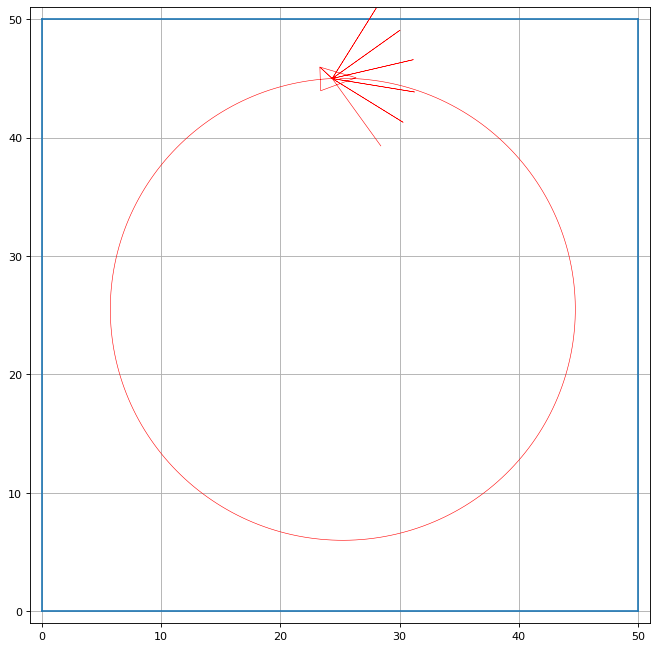

In [8]:
init_world(50, 50)
robot = Robot(25, 45, 0.0)

def circle_controller(robot, frame):
  robot.set_speed(5, 4.75)

# Same as above, but now without animating the simulation (just show the result)
run_experiment(robot=robot, controller=circle_controller, frames=250, animate=False)

## Obstacles and sensors

We can also add obstacles and have the robot respond to them.

In [9]:
init_world(50, 50)

robot = Robot(5, 5, 0.5)
# Add two rectangular obstacles:
add_rectangular_obstacle(10, 1, 40, 15)
add_rectangular_obstacle(1, 30, 49, 40)

# We define the robot's behavior
def simple_obstacle_avoidance(robot, frame):
  readings = robot.get_sensor_readings()
  # if there is something on the left, turn right
  if readings[1] < 4.5:
    robot.set_speed(1.5, -2)
  
  # if there is something on the right, turn left
  elif readings[-2] < 4.5:
    robot.set_speed(-2, 1.5)

  # otherwise, go (almost) straight
  else:  
    robot.set_speed(4, 3.98)

run_experiment(robot=robot, controller=simple_obstacle_avoidance, frames=250, animate=True)


Creating animation of 250 frames


# Exercise


Develop a fuzzy logic controller for a robot that enables the robot to avoid obstacles while navigating to a predefined destination given either by a point or a region in the world. The robot's relative orientation with respect to the predefined destination should be made available to the controller and your control logic must take that information into account, e.g. make the controller go towards the destination if no obstacle is detected.

You must define a rule-base, linguistic variables, linguistic values, and membership functions. 

While your controller does not need to be perfect and capable of handling every situation that the robot may encounter, you should test your solution(s) well and explain when it works/fails and why. You should therefore run multiple experiments with different configurations of obstacles, and you should consider collecting performance statistics.

You are welcome to make reasonable changes and additions to the ```Robot``` class and the utility functions. Adding sensors to the robot or changing the sensor range is, for instance, reasonable, but enabling God mode by making the robot invulnerable to obstacles is **not**, of course. 

/Users/balling/projects/AI/env/lib/python3.9/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


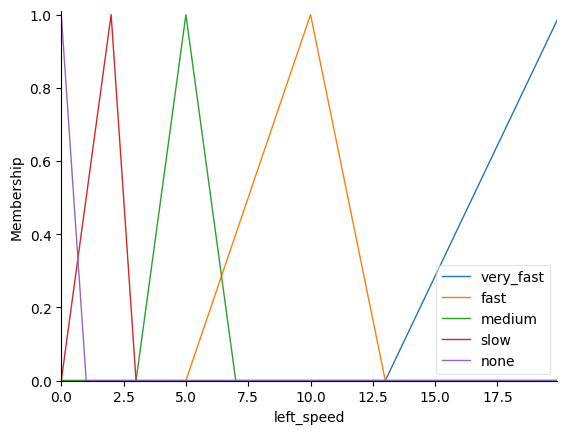

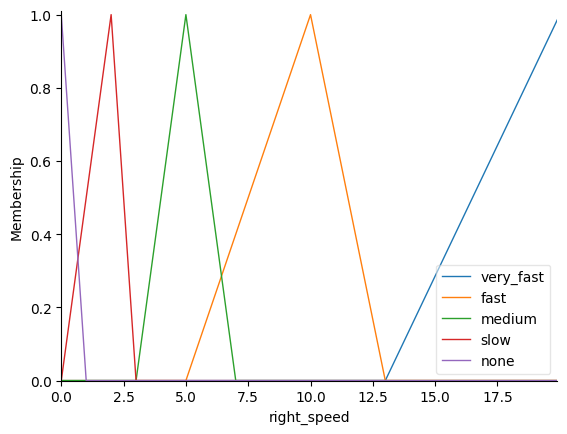

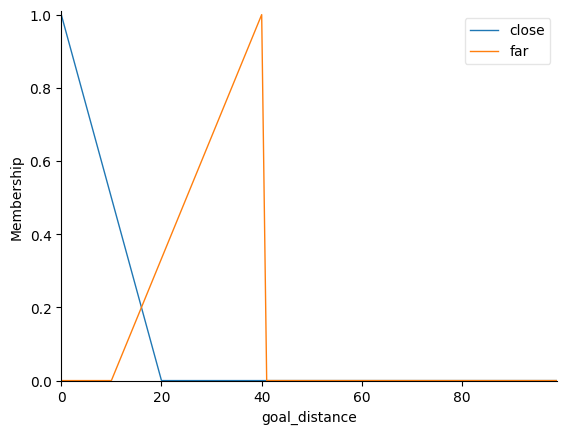

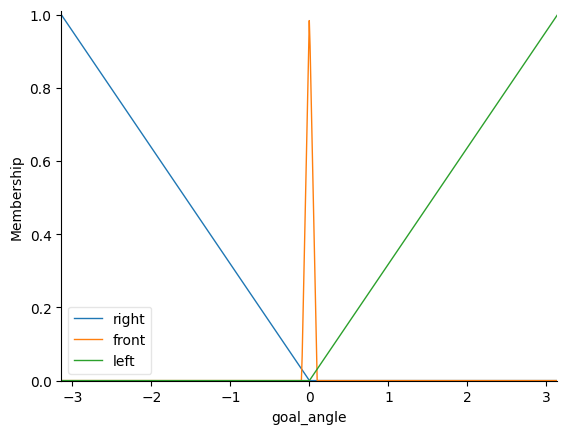

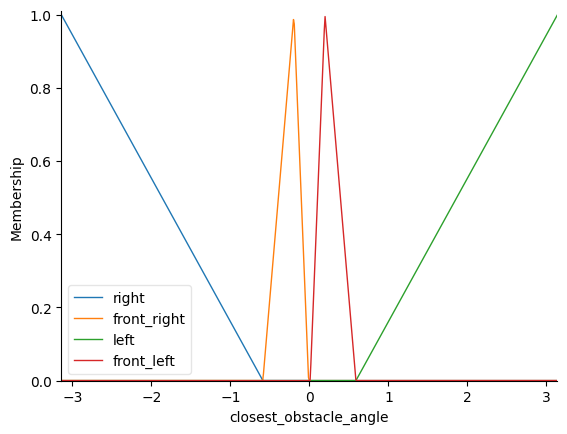

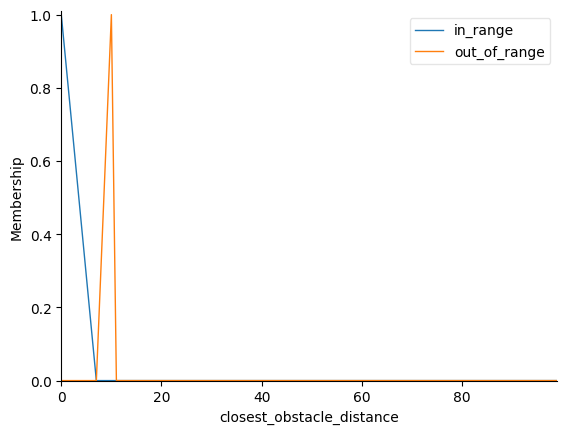

In [10]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Create Fuzzy controller
# Create the universe variables
universe_speed = np.arange(0, 20, 0.1)
universe_range = np.arange(0, 100, 1)
universe_angle = np.arange(-np.pi, np.pi, 0.01)
universe_sensor_range = np.arange(0, 7, 0.1)

# Output variables (speed of the left and right wheels)
speed_left = ctrl.Consequent(universe_speed,'left_speed')
speed_left['very_fast'] = fuzz.trimf(speed_left.universe, [13, 20, 20])
speed_left['fast'] = fuzz.trimf(speed_left.universe, [5, 10, 13])
speed_left['medium'] = fuzz.trimf(speed_left.universe, [3, 5, 7])
speed_left['slow'] = fuzz.trimf(speed_left.universe, [0, 2, 3])
speed_left['none'] = fuzz.trimf(speed_left.universe, [0, 0, 1])
speed_left.view()

speed_right = ctrl.Consequent(universe_speed,'right_speed')
speed_right['very_fast'] = fuzz.trimf(speed_right.universe, [13, 20, 20])
speed_right['fast'] = fuzz.trimf(speed_right.universe, [5, 10, 13])
speed_right['medium'] = fuzz.trimf(speed_right.universe, [3, 5, 7])
speed_right['slow'] = fuzz.trimf(speed_right.universe, [0, 2, 3])
speed_right['none'] = fuzz.trimf(speed_right.universe, [0, 0, 1])
speed_right.view()

# Input variables (goal distance, goal angle, and obstacle readings)
goal_distance = ctrl.Antecedent(universe_range,'goal_distance')
goal_distance['close'] = fuzz.trimf(goal_distance.universe, [0, 0, 20])
goal_distance['far'] = fuzz.trimf(goal_distance.universe, [10, 40, 40])
goal_distance.view()

goal_angle = ctrl.Antecedent(universe_angle,'goal_angle')
goal_angle['right'] = fuzz.trimf(goal_angle.universe, [-np.pi, -np.pi, 0])
goal_angle['front'] = fuzz.trimf(goal_angle.universe, [-np.pi/32, 0, np.pi/32])
goal_angle['left'] = fuzz.trimf(goal_angle.universe, [0, np.pi, np.pi])
goal_angle.view()

closest_obstacle_angle = ctrl.Antecedent(universe_angle,'closest_obstacle_angle')
closest_obstacle_angle['right'] = fuzz.trimf(closest_obstacle_angle.universe, [-np.pi, -np.pi, -3 * math.pi / 16.0])
closest_obstacle_angle['front_right'] = fuzz.trimf(closest_obstacle_angle.universe, [-3 * math.pi / 16.0, -math.pi / 16.0, -0.01])
closest_obstacle_angle['left'] = fuzz.trimf(closest_obstacle_angle.universe, [3 * math.pi / 16.0,np.pi, np.pi])
closest_obstacle_angle['front_left'] = fuzz.trimf(closest_obstacle_angle.universe, [0.01, math.pi / 16.0, 3 * math.pi / 16.0])
closest_obstacle_angle.view()

closest_obstacle_distance = ctrl.Antecedent(universe_range,'closest_obstacle_distance')
closest_obstacle_distance['in_range'] = fuzz.trimf(closest_obstacle_distance.universe, [0, 0, 7])
closest_obstacle_distance['out_of_range'] = fuzz.trimf(closest_obstacle_distance.universe, [7, 10, 10])
closest_obstacle_distance.view()


# Create rules
rule1 = ctrl.Rule(goal_distance['close'], (speed_left['none'], speed_right['none']))
rule2 = ctrl.Rule(goal_distance['far'], (speed_left['slow'], speed_right['slow']))
rule3 = ctrl.Rule(goal_angle['left'], (speed_left['none'], speed_right['slow']))
rule4 = ctrl.Rule(goal_angle['right'], (speed_left['slow'], speed_right['none']))
rule5 = ctrl.Rule(goal_angle['front'], (speed_left['medium'], speed_right['medium']))
rule6 = ctrl.Rule(closest_obstacle_distance['in_range'] & closest_obstacle_angle['left'], (speed_left['fast'], speed_right['slow']))
rule7 = ctrl.Rule(closest_obstacle_distance['in_range'] & closest_obstacle_angle['front_left'], (speed_left['very_fast'], speed_right['slow']))
rule8 = ctrl.Rule(closest_obstacle_distance['in_range'] & closest_obstacle_angle['right'], (speed_left['slow'], speed_right['fast']))
rule9 = ctrl.Rule(closest_obstacle_distance['in_range'] & closest_obstacle_angle['front_right'], (speed_left['slow'], speed_right['very_fast']))
rule10 = ctrl.Rule(closest_obstacle_distance['out_of_range'], (speed_left['fast'], speed_right['fast']))

robot_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5 ,rule6, rule7, rule8, rule9, rule10])
robot_sim = ctrl.ControlSystemSimulation(robot_ctrl)


Robot at position [5, 5], facing direction -2.791386265398351, goal at [70, 70]


/var/folders/hr/gbh02hzs4wvf1npdvslsh1d80000gn/T/ipykernel_15689/4279739140.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_fig.show()


Robot survived!
Robot reached the goal!

Robot at position [40, 40], facing direction -1.2584172580017121, goal at [70, 70]
Robot survived!
Robot reached the goal!

Robot at position [10, 40], facing direction -2.255859662911052, goal at [70, 70]
Robot survived!
Robot reached the goal!

Robot at position [30, 5], facing direction -3.018570698256435, goal at [70, 70]
Robot survived!
Robot reached the goal!

Robot at position [10, 90], facing direction -0.8440440642172504, goal at [70, 70]
Robot survived!
Robot reached the goal!

Robot at position [90, 10], facing direction 0.0945884046450776, goal at [70, 70]
Robot survived!
Robot reached the goal!


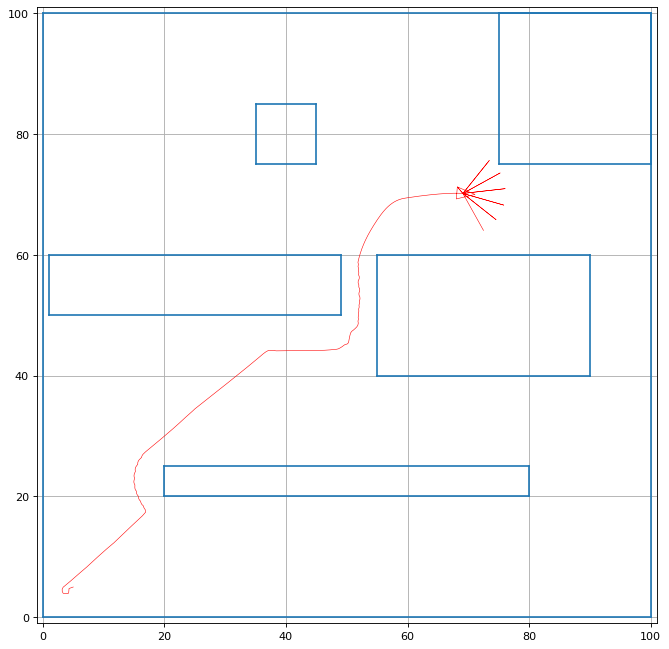

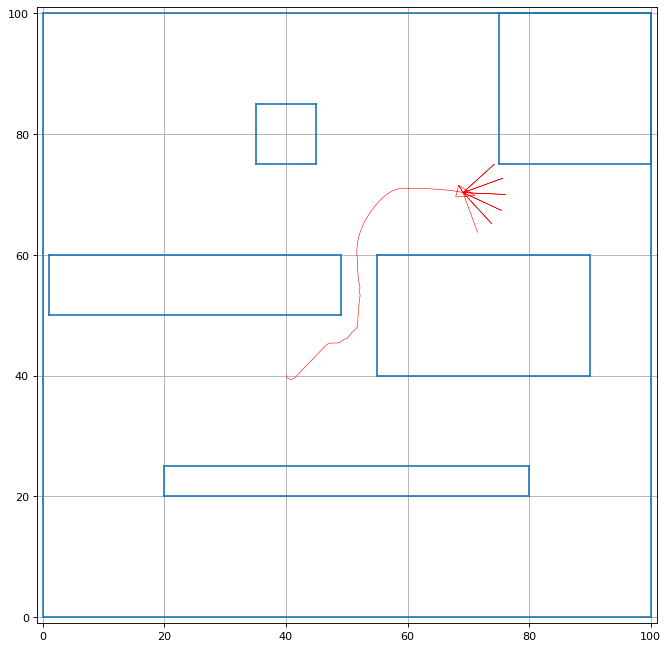

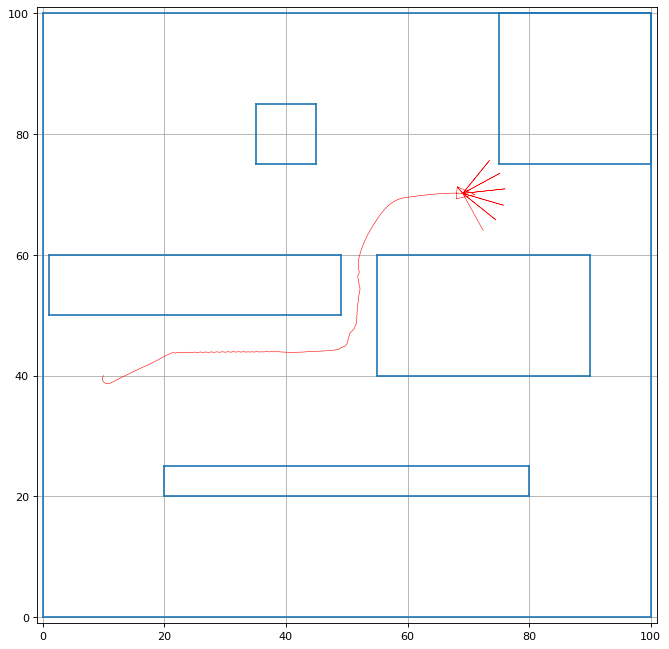

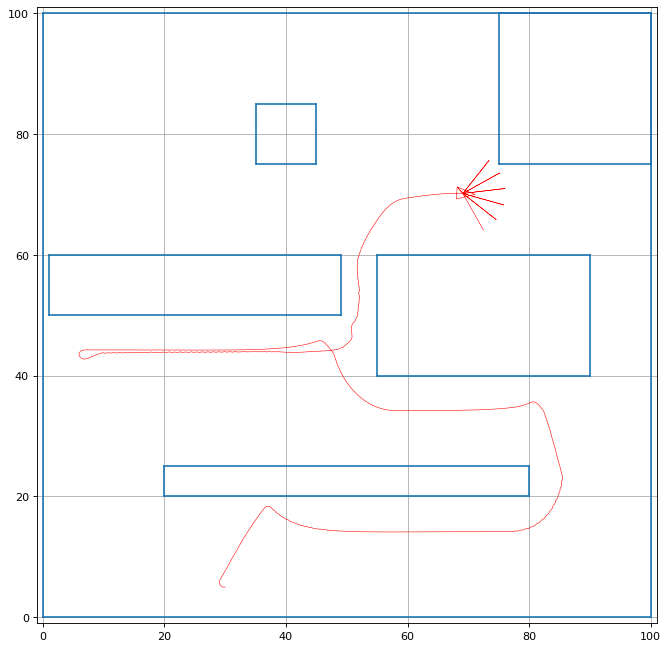

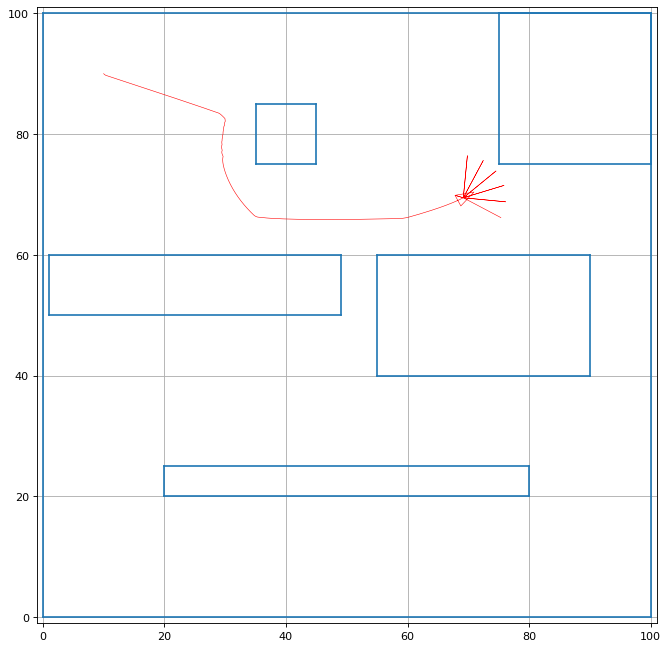

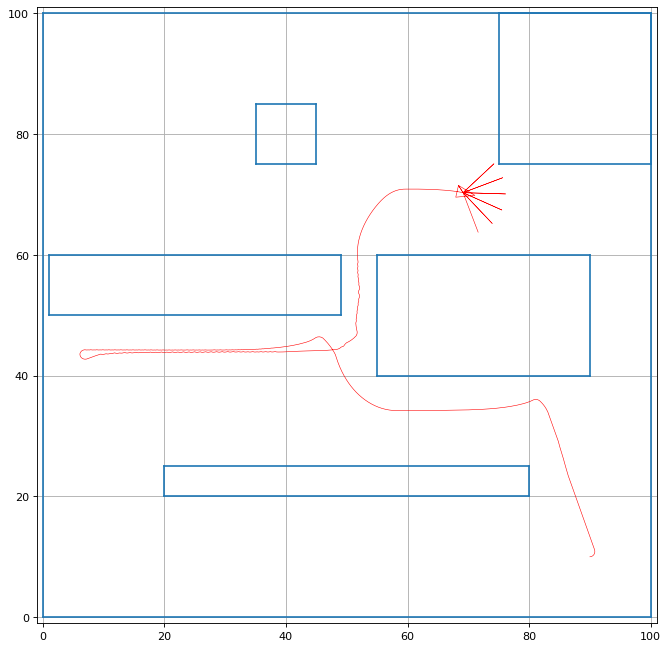

In [11]:
# Create environment variables
robot_pos = [[5, 5], [40, 40], [10, 40], [30, 5], [10, 90], [90, 10]]
for pos in robot_pos:
    init_world(100, 100)
    # Set goal position
    goal = [70, 70]
    # Generate a random direction for the robot
    direction = np.random.uniform(-np.pi, np.pi)
    print("\nRobot at position {}, facing direction {}, goal at {}".format(pos, direction, goal))
    robot = Robot(pos[0],pos[1], direction)
    sensor_range = robot.sensor_range
    # Add two rectangular obstacles:
    add_rectangular_obstacle(20, 20, 80, 25)
    add_rectangular_obstacle(1, 50, 49, 60)
    add_rectangular_obstacle(75, 75, 100, 100)
    add_rectangular_obstacle(55, 40, 90, 60)
    add_rectangular_obstacle(35, 75, 45, 85)
    

    # Create Fuzzy controller
    def fuzzy_obstacle_avoidance(robot, frame):
        goal_dist = robot.get_distance_goal(goal)
        # If the goal is reached, stop
        if goal_dist < 1:
            robot.set_speed(0, 0)
            return
        goal_ang = robot.get_angle_goal(goal)
        readings = robot.get_sensor_readings()
        distance, angle = 9999, -np.pi
        for i, reading_dist in enumerate(readings):
            if reading_dist < distance:
                distance = reading_dist
                angle = robot.sensors[i]
        if distance >= robot.sensor_range:
            # No obstacle in sight, go to the goal
            distance = 1000
            angle = np.pi

        # Set the inputs to the fuzzy controller
        robot_sim.input['goal_distance'] = goal_dist
        robot_sim.input['goal_angle'] = goal_ang
        robot_sim.input['closest_obstacle_angle'] = angle
        robot_sim.input['closest_obstacle_distance'] = distance
        # Compute the control action
        robot_sim.compute()
        
        # Get the final control action for the robot
        speed_left = robot_sim.output['left_speed']
        speed_right = robot_sim.output['right_speed']

        # Set the robot speed based on the control action
        robot.set_speed(speed_left, speed_right)

    # Run the simulation
    run_experiment(robot=robot, controller=fuzzy_obstacle_avoidance, frames=2000, animate=False)
    if robot.is_alive():
        print("Robot survived!")
    else:
        print("Robot crashed!")
    if robot.get_distance_goal(goal) < 1:
        print("Robot reached the goal!")
    else:
        print("Robot did not reach the goal! The robot ended at position {}".format(robot.get_pose()))


Robot at position [30, 5], facing direction 0.0084755159183425, goal at [70, 70]
Robot survived!
Robot reached the goal!


/var/folders/hr/gbh02hzs4wvf1npdvslsh1d80000gn/T/ipykernel_15689/4279739140.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_fig.show()


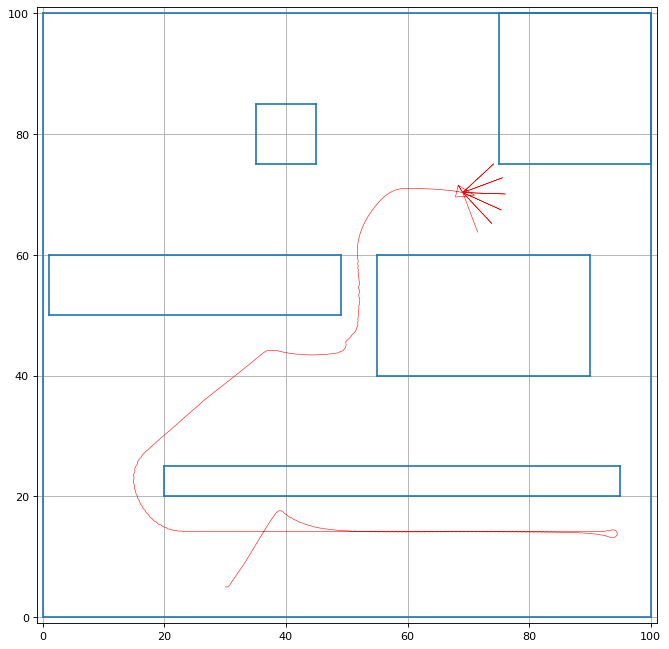

In [15]:
# For one off simulation
pos = [30, 5]
goal = [70, 70]
direction = 0.0084755159183425

init_world(100, 100)
print("\nRobot at position {}, facing direction {}, goal at {}".format(pos, direction, goal))
robot = Robot(pos[0],pos[1], direction)
sensor_range = robot.sensor_range
# Add two rectangular obstacles:
add_rectangular_obstacle(20, 20, 95, 25)
add_rectangular_obstacle(1, 50, 49, 60)
add_rectangular_obstacle(75, 75, 100, 100)
add_rectangular_obstacle(55, 40, 90, 60)
add_rectangular_obstacle(35, 75, 45, 85)


# Create Fuzzy controller
def fuzzy_obstacle_avoidance(robot, frame):
    goal_dist = robot.get_distance_goal(goal)
    # If the goal is reached, stop
    if goal_dist < 1:
        robot.set_speed(0, 0)
        return
    goal_ang = robot.get_angle_goal(goal)
    readings = robot.get_sensor_readings()
    distance, angle = 9999, -np.pi
    for i, reading_dist in enumerate(readings):
        if reading_dist < distance:
            distance = reading_dist
            angle = robot.sensors[i]
    if distance >= robot.sensor_range:
        # No obstacle in sight, go to the goal
        distance = 1000
        angle = np.pi

    # Set the inputs to the fuzzy controller
    robot_sim.input['goal_distance'] = goal_dist
    robot_sim.input['goal_angle'] = goal_ang
    robot_sim.input['closest_obstacle_angle'] = angle
    robot_sim.input['closest_obstacle_distance'] = distance
    # Compute the control action
    robot_sim.compute()
    
    # Get the final control action for the robot
    speed_left = robot_sim.output['left_speed']
    speed_right = robot_sim.output['right_speed']

    # Set the robot speed based on the control action
    robot.set_speed(speed_left, speed_right)

# Run the simulation
run_experiment(robot=robot, controller=fuzzy_obstacle_avoidance, frames=2000, animate=False)
if robot.is_alive():
    print("Robot survived!")
else:
    print("Robot crashed!")
if robot.get_distance_goal(goal) < 1:
    print("Robot reached the goal!")
else:
    print("Robot did not reach the goal! The robot ended at position {}".format(robot.get_pose()))